# Investigate why Gemma 3 Fisher information seems to fail to predict error

**TL;DR** It turns out that this is due to a bug in the calculation of Fisher information on Gemma 3. They have a `class Gemma3TextScaledWordEmbedding(nn.Embedding)` which modifies `forward()`. When we wrap these `nn.Embedding` instances in our Fisher sensitivity calculator, we undo the custom scaling, so the forward pass computation is then incorrect, throwing off gradient information for all succeeding layers. This affects Fisher sensitivity, variable bit allocation, and Fisher-weighted Lloyd-max/search for Gemma 3 only.

In [2]:
%load_ext autoreload
%autoreload 2

import collections
import numpy as np
import re
import tqdm
import torch
from torch import tensor, Tensor
import transformers
from typing import Any, Iterable

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import weight_formats.experiments as E

transformers.utils.logging.disable_progress_bar()
matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def mname(model_id: str) -> str:
    return model_id.split("/")[-1]

## Analysis

In [2]:
FISHER_SUM = {mname(run.config.model): run.summary.fisher for run in E.runs("20250423-fisher")}
WEIGHT_STATS = {mname(run.config.model): run.summary.weight_stats for run in E.runs("20250423-weight-stats")}

SENSITIVITY_KL = collections.defaultdict(lambda: collections.defaultdict(dict))
for run in E.runs("20250502-noise-sensitivity"):
    if run.meta.status == "finished" and "vision_model" not in run.config.test.parameter and "multi_modal_projector" not in run.config.test.parameter:
        SENSITIVITY_KL[mname(run.config.model)][run.config.test.scale][run.config.test.parameter] = tensor(run.summary.kl_div).mean().item()

In [10]:
def get_rows() -> Iterable[dict[str, Any]]:
    for model in SENSITIVITY_KL:
        for scale in SENSITIVITY_KL[model]:
            for parameter in SENSITIVITY_KL[model][scale]:
                yield dict(
                    model=model,
                    scale=scale,
                    parameter=parameter,
                    fisher_sum=FISHER_SUM[model][parameter],
                    rm2=WEIGHT_STATS[model][parameter].rm2,
                    kl_div=SENSITIVITY_KL[model][scale][parameter],
                )

df = pd.DataFrame.from_records(get_rows())
df["kl_div_prediction"] = 0.5 * (df.scale * df.rm2)**2 * df.fisher_sum
df["parameter_kind"] = df.parameter.apply(lambda s: s.split(".")[-2])
df["layer"] = df.parameter.apply(lambda s: float(p.group(1)) if (p := re.search(r"\.(\d+)\.", s)) else None)
df.head()

,model,scale,parameter,fisher_sum,rm2,kl_div,kl_div_prediction,parameter_kind,layer
0,Llama-3.2-1B,0.25,model.embed_tokens.weight,7028.244600,0.021907,0.100927,0.105403,embed_tokens,NaN
1,Llama-3.2-1B,0.25,model.layers.0.self_attn.q_proj.weight,7.463257,0.036875,0.001434,0.000317,q_proj,0.0
2,Llama-3.2-1B,0.25,model.layers.0.self_attn.k_proj.weight,12.020443,0.047735,0.002423,0.000856,k_proj,0.0
3,Llama-3.2-1B,0.25,model.layers.0.self_attn.v_proj.weight,1267.261500,0.009144,0.006154,0.003311,v_proj,0.0
4,Llama-3.2-1B,0.25,model.layers.0.self_attn.o_proj.weight,736.610960,0.011592,0.005260,0.003093,o_proj,0.0


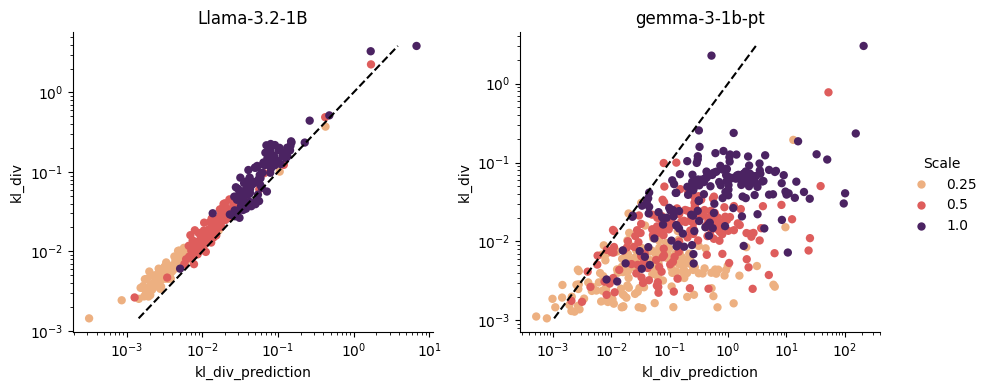

In [11]:
_, axs = plt.subplots(ncols=2, figsize=(9, 4))
for model, ax in zip(["Llama-3.2-1B", "gemma-3-1b-pt"], axs):
    d = df[(df.model==model)]
    sns.scatterplot(d, y="kl_div", x="kl_div_prediction", lw=0, hue="scale", palette="flare", ax=ax)
    ax.set_xscale("log")
    ax.set_yscale("log")
    xs = d.kl_div.quantile([0, 1])
    ax.plot(xs, xs, "k--")
    ax.set_title(model)
    ax.legend_.remove()
axs[0].figure.legend(*axs[0].get_legend_handles_labels(), title="Scale", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

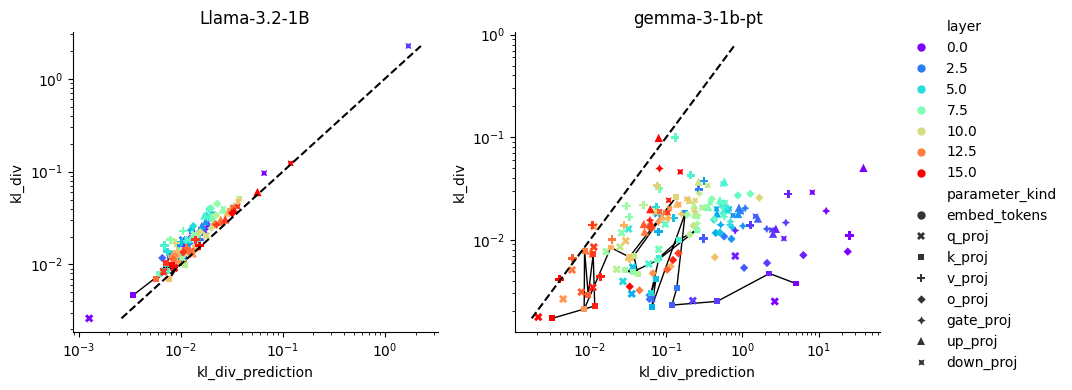

In [60]:
_, axs = plt.subplots(ncols=2, figsize=(9, 4))
for model, ax in zip(["Llama-3.2-1B", "gemma-3-1b-pt"], axs):
    d = df[(df.scale==0.5) & (df.model==model)]
    sns.scatterplot(d, y="kl_div", x="kl_div_prediction", lw=0, hue="layer", style="parameter_kind", palette="rainbow", ax=ax)
    g = d[d.parameter_kind=="k_proj"].sort_values("layer")
    ax.plot(g.kl_div_prediction, g.kl_div, color="k", lw=1, zorder=0)
    ax.set_xscale("log")
    ax.set_yscale("log")
    xs = d.kl_div.quantile([0, 1])
    ax.plot(xs, xs, "k--")
    ax.set_title(model)
    ax.legend_.remove()
axs[0].figure.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Recalculate Fisher

In [2]:
WEIGHT_STATS_RERUN = {mname(run.config.model): run.summary.weight_stats for run in E.runs("20250603-gemma-sensitivity-stats")}
SENSITIVITY_KL_RERUN = collections.defaultdict(lambda: collections.defaultdict(dict))
for run in E.runs("20250603-gemma-sensitivity-debug"):
    if run.meta.status == "finished":
        SENSITIVITY_KL_RERUN[mname(run.config.model)][run.config.test.scale][run.config.test.parameter] = tensor(run.summary.kl_div).mean().item()

In [ ]:
FISHER_RERUN = {}
for model_id in ["google/gemma-3-1b-pt", "google/gemma-2-2b", "google/gemma-2b"]:
    model = transformers.AutoModelForCausalLM.from_pretrained(
        model_id, device_map=DEVICE, torch_dtype=torch.bfloat16,
    )
    data = E.token_prediction.Dataset.load(model, 1024, 1, 0, 128)
    FISHER_RERUN[mname(model_id)] = {k: v.sum() for k, v in E.fisher.diag_fisher(data, model, mode="single_sample", progress=True).items()}
    del model
    del data
    import gc
    gc.collect()
    torch.cuda.empty_cache()

fisher: 100%|██████████| 128/128 [01:48<00:00,  1.18it/s]


In [4]:
def get_rows() -> Iterable[dict[str, Any]]:
    for model in FISHER_RERUN:
        for scale in SENSITIVITY_KL_RERUN[model]:
            for parameter in SENSITIVITY_KL_RERUN[model][scale]:
                yield dict(
                    model=model,
                    scale=scale,
                    parameter=parameter,
                    fisher_sum=FISHER_RERUN[model][parameter].item(),
                    rm2=WEIGHT_STATS_RERUN[model][parameter].rm2,
                    kl_div=SENSITIVITY_KL_RERUN[model][scale][parameter],
                )

df = pd.DataFrame.from_records(get_rows())
df["kl_div_prediction"] = 0.5 * (df.scale * df.rm2)**2 * df.fisher_sum
df["parameter_kind"] = df.parameter.apply(lambda s: s.split(".")[-2])
df["layer"] = df.parameter.apply(lambda s: float(p.group(1)) if (p := re.search(r"\.(\d+)\.", s)) else None)
df.head()

,model,scale,parameter,fisher_sum,rm2,kl_div,kl_div_prediction,parameter_kind,layer
0,gemma-3-1b-pt,0.25,model.embed_tokens.weight,6842.266113,0.030839,0.200474,0.203359,embed_tokens,NaN
1,gemma-3-1b-pt,0.25,model.layers.0.self_attn.q_proj.weight,17.103680,0.025781,0.001496,0.000355,q_proj,0.0
2,gemma-3-1b-pt,0.25,model.layers.0.self_attn.k_proj.weight,13.540480,0.033672,0.001624,0.000480,k_proj,0.0
3,gemma-3-1b-pt,0.25,model.layers.0.self_attn.v_proj.weight,15.599738,0.033672,0.003067,0.000553,v_proj,0.0
4,gemma-3-1b-pt,0.25,model.layers.0.self_attn.o_proj.weight,123.357918,0.018759,0.002696,0.001357,o_proj,0.0


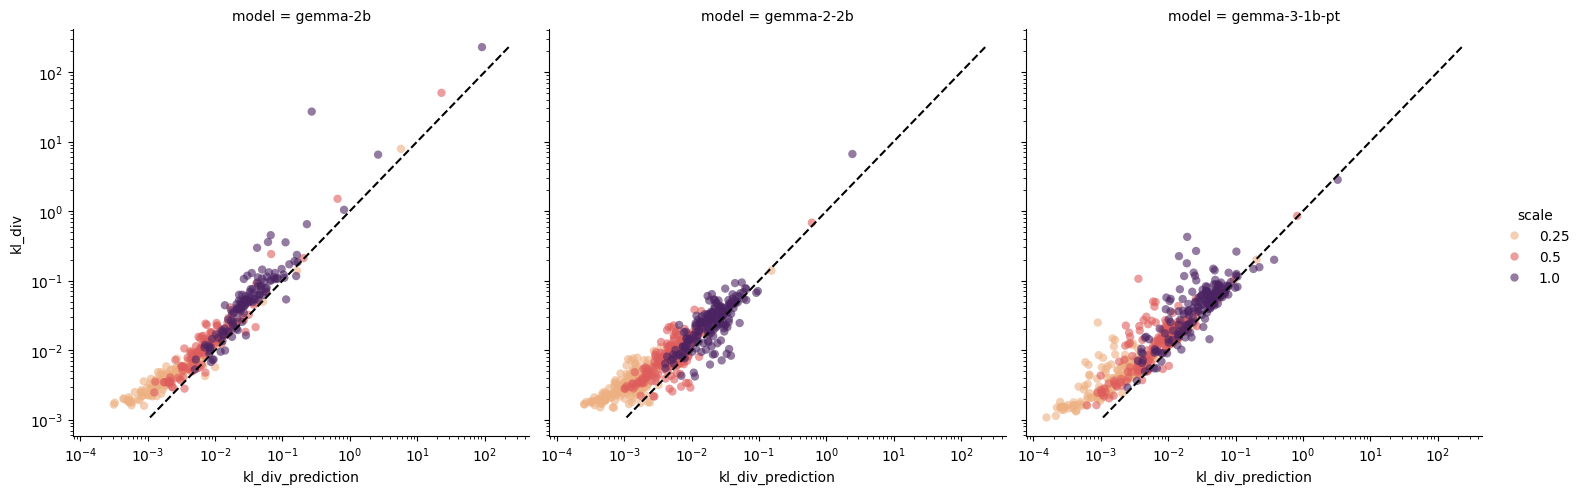

In [ ]:
g = sns.relplot(data=df, y="kl_div", x="kl_div_prediction", lw=0, hue="scale", palette="flare", col="model", alpha=.6)
for ax in g.axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    xs = df.kl_div.quantile([0, 1])
    ax.plot(xs, xs, "k--")

In [ ]:
g3_config = transformers.AutoConfig.from_pretrained("google/gemma-3-1b-pt").to_dict()
g2_config = transformers.AutoConfig.from_pretrained("google/gemma-2-2b").to_dict()
display(pd.DataFrame.from_records([
    (k, g2_config.get(k), g3_config.get(k))
    for k in sorted(set(g3_config) | set(g2_config))
    if g3_config.get(k) != g2_config.get(k)
]))

,0,1,2
0,_name_or_path,google/gemma-2-2b,google/gemma-3-1b-pt
1,architectures,[Gemma2ForCausalLM],[Gemma3ForCausalLM]
2,attn_logit_softcapping,50.0,None
3,final_logit_softcapping,30.0,None
4,hidden_act,gelu_pytorch_tanh,None
5,hidden_size,2304,1152
6,intermediate_size,9216,6912
7,max_position_embeddings,8192,32768
8,model_type,gemma2,gemma3_text
9,num_attention_heads,8,4


## Debug #2

In [3]:
fisher_sum, = [run.summary.fisher for run in E.runs("20250604-fisher") if run.config.model == "google/gemma-3-1b-pt"]

In [20]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    "google/gemma-3-1b-pt", device_map=DEVICE, torch_dtype=torch.bfloat16, attn_implementation="eager"
)
data = E.token_prediction.Dataset.load(model, 4096, 1, 0, 1024, dataset=("wikitext", ("train",)), line_limit=int(1e5), progress=True)
with E.fisher.activation_checkpointing_enabled(model):
    fisher_sum_rerun = {k: v.sum() for k, v in E.fisher.diag_fisher(data, model, mode="single_sample", progress=True).items()}
torch.save(fisher_sum_rerun, "tmp_debug/tr_cp_eager_s4096_n1024.th")

fisher: 100%|██████████| 1024/1024 [15:54<00:00,  1.07it/s]


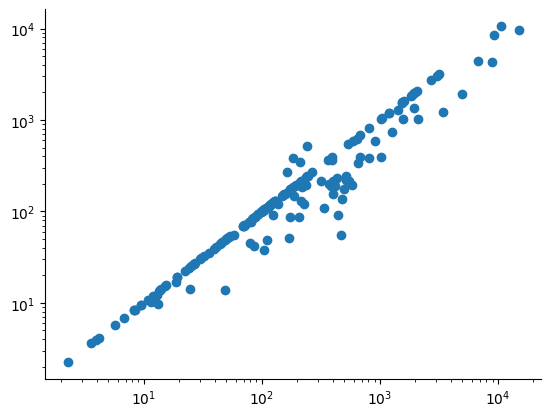

In [5]:
_, ax = plt.subplots()
ax.scatter([fisher_sum[k] for k in fisher_sum], [fisher_sum_rerun[k] for k in fisher_sum])
ax.set_xscale("log")
ax.set_yscale("log")